In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.utils import np_utils, plot_model


import cv2
from glob import glob
from sklearn.utils import shuffle
from time import time


import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 查看類別資寮夾(label)
os.listdir("./training_set")[0:9]

['akane', 'rika', 'neru', 'yui', '.ipynb_checkpoints', 'risa']

In [3]:
# 查看類別資料夾裡的資料
os.listdir("./training_set/akane")[0:9]

['092.png',
 '073.png',
 '062.png',
 '100.png',
 '055.png',
 '087.png',
 '083.png',
 '082.png',
 '090.png']

In [4]:
os.listdir("./testing_set")[0:9]

['86B9F51B85.png',
 '65BF2008F2.png',
 'F1FB9BD260.png',
 '4318710884.png',
 'B9CA8A32DF.png',
 '538CFE6771.png',
 '40FD801394.png',
 '27C5695794.png',
 '8C15F15BFE.png']

In [5]:
# 類別編碼
pd.read_csv('./classmap.csv')[0:9]

,classname,classnum
0,rika,0
1,risa,1
2,yui,2
3,akane,3
4,neru,4


In [6]:
# target_label_file_name = 'classmap.csv'

target_label_file_path = './classmap.csv'
# Opening a file using "with" is as simple as: with open(filename) as file:
# 在 f 資料夾讀一筆，則 .splitlines():返回一個包含各列作為元素的列表，然後 line.split(', ') 代表用 ', ' 分隔相鄰列表
with open(target_label_file_path) as f:
    all_lines = [line.split(',') for line in f.read().splitlines()]
    
all_lines = all_lines[1::]
# 將list 換成dic的形式
target_labels = dict()
for line in all_lines:
    target_class, target_label = line
    target_labels[target_class] = target_label

In [7]:
target_labels

{'rika': '0', 'risa': '1', 'yui': '2', 'akane': '3', 'neru': '4'}

# Training Data

In [8]:
# 指定存放 train 資料集的資料夾
train_dir = "./training_set"
img_path_list = []
img_class_list = []
# 利用迴圈依序用字典的 key 找出該類別(key)的路徑，再透過 glob() 找出路徑下的所有文件，
# 並透過迴圈每找到一個文件，就在 img_class_list 裡增加一個該類的的 label
for key in target_labels.keys():
    for file_path in glob('{}/{}/*.png'.format(train_dir, key)):     # glob: 返回所有匹配的文件路徑列表
        img_class_list.append(target_labels[key])                    # {}.format() : 將()裡的東西，變成{}形式的字串
        img_path_list.append(file_path)

data_list = pd.DataFrame({'class': img_class_list, 'path': img_path_list})

In [9]:
data_list.head(10)

,class,path
0,0,./training_set/rika/092.png
1,0,./training_set/rika/073.png
2,0,./training_set/rika/062.png
3,0,./training_set/rika/055.png
4,0,./training_set/rika/087.png
5,0,./training_set/rika/083.png
6,0,./training_set/rika/082.png
7,0,./training_set/rika/090.png
8,0,./training_set/rika/047.png
9,0,./training_set/rika/023.png


In [10]:
# 改成list 形式 ，才能當 for 迴圈的 index
img_paths_list = data_list['path']
img_labels_list = data_list['class']
train_img_paths, valid_img_paths, y_train, y_valid = train_test_split(img_paths_list, img_labels_list, test_size=0.1)

In [11]:
print('Some training samples:\n----------------------')
print(train_img_paths.head())

print('\nSome training labels:\n---------------------')
print(y_train.head())

print('\nSome validation samples:\n------------------------')
print(valid_img_paths.head())

print('\nSome validation labels:\n-----------------------')
print(y_valid.head())

Some training samples:
----------------------
504     ./training_set/neru/114.png
285      ./training_set/yui/053.png
490     ./training_set/neru/107.png
393    ./training_set/akane/063.png
514     ./training_set/neru/105.png
Name: path, dtype: object

Some training labels:
---------------------
504    4
285    2
490    4
393    3
514    4
Name: class, dtype: object

Some validation samples:
------------------------
261     ./training_set/yui/012.png
165    ./training_set/risa/086.png
214     ./training_set/yui/103.png
42     ./training_set/rika/009.png
211     ./training_set/yui/047.png
Name: path, dtype: object

Some validation labels:
-----------------------
261    2
165    1
214    2
42     0
211    2
Name: class, dtype: object


# keras

In [12]:
num_classes = 5 #label 的類別數
epochs = 100
batch_size = 32

img_size = 299

In [13]:
def load_data(Gray2RGB= False, mean_proc=False, img_size=img_size, test_data = True):
    
#         """ Split the list into training set and validation set """
    
    X_train = []
    for path in train_img_paths:
        img = cv2.imread(path, 0)   # 讀取圖檔，後面的 0 代表讀取圖檔為灰階形式
        img = cv2.resize(img, (img_size, img_size))
        
        if Gray2RGB == True:        # 灰階轉 RGB 檔
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        img = img.astype(np.float32) #將圖片轉成數字
            
        # 平均數處理    
        if mean_proc == 'VGG16_ImageNet':
            img = img - np.array([123.68, 116.779, 103.939]) # RGB channel 的平均數(官方給的)
            img = img[:,:,::-1]  # RGB 轉為 BGR， 因為 pre-train 好的 model，channel 為 BGR
            img = (img - np.min(img)) / np.max(img)
        if mean_proc == 'DenseNet':
            # img /= 255.
            img /= 299.
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img - mean) / std
        else:
            # img /= 255.
            img /= 299.
            img -= 0.5
            img *= 2.
            
        X_train.append(img)
    X_train = np.array(X_train, dtype=np.float32)
    
    X_valid = []
    if test_data == True:
        for path in valid_img_paths:
            img = cv2.imread(path, 0)
            img = cv2.resize(img, (img_size, img_size))

            if Gray2RGB == True:
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            
            img = img.astype(np.float32)
            
            if mean_proc == 'VGG16_ImageNet':
                img = img - np.array([123.68, 116.779, 103.939])
                img = img[:,:,::-1]  # RGB to BGR
                img = (img - np.min(img)) / np.max(img)
            if mean_proc == 'DenseNet':
                # img /= 255.
                img /= 299.
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = (img - mean) / std
            else:
                #img /= 255.
                img /= 299.
                img -= 0.5
                img *= 2.
            X_valid.append(img)
    X_valid = np.array(X_valid, dtype=np.float32)
    
    if Gray2RGB == False:
        X_train = np.reshape(X_train, X_train.shape+(1,))  # .shape+(1,) : 多加一個維度且數目是 1，為了顯示 channel 為一
        X_valid = np.reshape(X_valid, X_valid.shape+(1,))
   
    
    return X_train, X_valid

In [14]:
X_train, X_valid = load_data(Gray2RGB= True, mean_proc=False, img_size=img_size, test_data = True)

In [15]:

# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)  #  num_classes: 總類別數
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(484, 299, 299, 3)
(484, 5)
(54, 299, 299, 3)
(54, 5)


In [17]:
# 創=建一個資料夾，若存在則取消創建
path = 'saved_models'
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')

In [18]:
model_name = 'InceptionResNetV2'

base_model = InceptionResNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [19]:
# Data generator with augmentation
## 定義一個產生器，在每看一個batch時，做資料增強，再fit model，實務上這樣做 model 可以看到更多樣的變化，
# 當然如果用事先資料增強的方法，當增強數據越多，結果也會越接近 realtime data augmentation，但儲存空間龐大
datagen = ImageDataGenerator(
    rotation_range=10,        # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,    # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,   # randomly shift images vertically (fraction of total height)
    shear_range=0.2,          
    zoom_range=0.2,
    horizontal_flip=True,    # randomly flip images
    fill_mode='nearest')     # 输入边界以外的点根据给定的模式填充：'constant': kkkkk|abcd|kkkkk (cval=k)                  #                                  'nearest': aaaaaaaa|abcd|dddddddd'
                             #                                  'reflect': abcddcba|abcd|dcbaabcd'wrap'
                             #                                  'wrap': abcdabcd|abcd|abcdabcd
optimizer = keras.optimizers.Adam(lr=10e-6)
# model 存檔的路徑
model_path = './saved_models/{}.h5'.format(model_name)
# 定義要 training 的時候需要記錄下來的結果
# monitor : 要監控的變數
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
# 定義 Early stopping 的函數
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
# 隨機從每一個 epoch當中抽出圖片做資料增強，然後才吐出 batch 的數量 fit model，但每一個 epoch 的數量不會改變喔
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
29/30 [============================>.] - ETA: 2s - loss: 1.7223 - acc: 0.1940
Epoch 00001: val_loss improved from inf to 1.73514, saving model to ./saved_models/InceptionResNetV2.h5
30/30 [==============================] - 211s 7s/step - loss: 1.7228 - acc: 0.1877 - val_loss: 1.7351 - val_acc: 0.1852
Epoch 2/200
29/30 [============================>.] - ETA: 0s - loss: 1.6052 - acc: 0.2522
Epoch 00002: val_loss improved from 1.73514 to 1.68987, saving model to ./saved_models/InceptionResNetV2.h5
30/30 [==============================] - 21s 699ms/step - loss: 1.6071 - acc: 0.2477 - val_loss: 1.6899 - val_acc: 0.2222
Epoch 3/200
29/30 [============================>.] - ETA: 0s - loss: 1.5860 - acc: 0.2974
Epoch 00003: val_loss improved from 1.68987 to 1.66643, saving model to ./saved_models/InceptionResNetV2.h5
30/30 [==============================] - 20s 665ms/step - loss: 1.5860 - acc: 0.2980 - val_loss: 1.6664 - val_acc: 0.2222
Epoch 4/200
29/30 [===========================

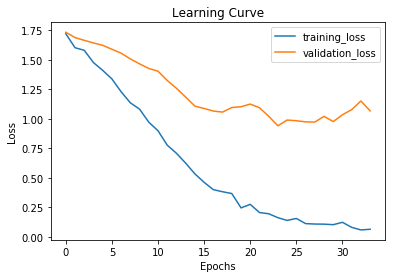

In [20]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

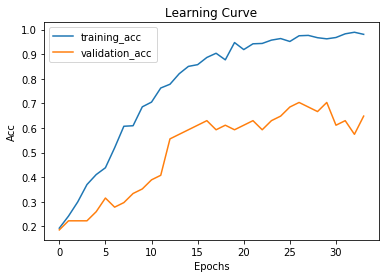

In [21]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

# Testing Data

In [22]:
def load_test_data(Gray2RGB=False, mean_proc=False, img_size=img_size):
    img_path_list = []
    #找出 rest data 的路徑
    for img_path in glob('{}/*.png'.format(testset_dir)):
        img_path_list.append(img_path)
        
    X_test = []
    X_id = []
    for path in img_path_list:
        img = cv2.imread(path, 0)
        img = cv2.resize(img, (img_size, img_size))
        
        if Gray2RGB == True:
            img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = img.astype(np.float32)

        if mean_proc == 'VGG16_ImageNet':
            img = img - np.array([123.68, 116.779, 103.939])
            img = img[:,:,::-1]  # RGB to BGR
            img = (img - np.min(img)) / np.max(img)
        if mean_proc == 'DenseNet':
            # img /= 255.
            img /= 299.
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img - mean) / std
        else:
            # img /= 255.
            img /= 299.
            img -= 0.5
            img *= 2.
            
        img_id = path.split('/')[-1].split('.')[0]
        X_test.append(img)
        X_id.append(img_id)
        
    X_test = np.array(X_test, dtype=np.float32)
    
    if Gray2RGB == False:
        X_test = np.reshape(X_test, X_test.shape+(1,))
    
    return X_test, X_id

In [23]:
# 指定存放 test 資料集的資料夾
testset_dir ="./testing_set"
testset_list = []
test_id_list = []

for img_path in glob('{}/*.png'.format(testset_dir)):
    testset_list.append(img_path)
    id = img_path.split('/')[-1].split('.')[0]  # -1 表示圖片路徑的最後一個 part，也就是圖片名，由於圖片名有加副檔名，
    test_id_list.append(id)                     # 所以用 '.' 做切割，取第0個
testset_df = pd.DataFrame({'id': test_id_list, 'path': testset_list}).sort_values(by='id')

In [24]:
print('\nSome testing samples:\n------------------------')
print(testset_df.head())
print('\ncomplete path samples:\n------------------------')
print(testset_df['path'][0])


Some testing samples:
------------------------
             id                          path
117  006F8606F6  ./testing_set/006F8606F6.png
85   00C22FC0EA  ./testing_set/00C22FC0EA.png
307  00CECD2708  ./testing_set/00CECD2708.png
246  0125D1C6C3  ./testing_set/0125D1C6C3.png
127  0158CDF991  ./testing_set/0158CDF991.png

complete path samples:
------------------------
./testing_set/86B9F51B85.png


In [ ]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./{}.csv'.format(model_name), index=False)

# 重起 kernel 後，load 模型，省去之前訓練模型的部分，最後加上以下的code

In [ ]:
# another_model = tf.keras.models.load_model('./saved_models/classic_CNN.h5')

In [ ]:
# X_test, X_id = load_test_data()
# y_test_pred = another_model.predict_classes(X_test)
# y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
# y_test_pred_df.head()